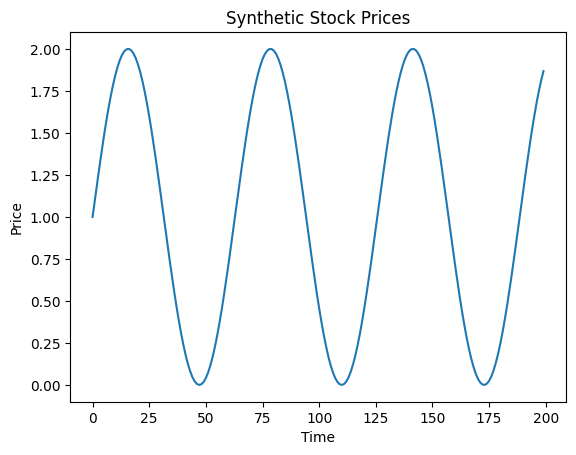

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def generate_prices(length=200):
    t = np.arange(length)
    prices = 1 + np.sin(t * 0.1)
    return pd.DataFrame({'Open': prices})

prices = generate_prices()
plt.plot(prices["Open"])
plt.title("Synthetic Stock Prices")
plt.xlabel("Time")
plt.ylabel("Price")
plt.show()

In [ ]:
import gymnasium as gym
import numpy as np

n_features = prices.shape[1]
observation_space = gym.spaces.Box(low=0, high=1, shape=(n_features,), dtype=np.float32)

print("Observation Space defined:")
print(observation_space)
print(f"Shape of observation space: {observation_space.shape}")

Observation Space defined:
Box(0.0, 1.0, (1,), float32)
Shape of observation space: (1,)


In [4]:
action_map = {
0: ("HOLD", 0),
1: ("BUY", 1),
2: ("BUY", 5),
3: ("BUY", 10),
4: ("SELL", 1),
5: ("SELL", 5),
6: ("SELL", 10),
}
name,num = action_map[0]
print(f"Action corresponds to: {name} , {num} shares")

Action corresponds to: HOLD , 0 shares


In [ ]:
import gymnasium as gym
import numpy as np
import pandas as pd

class StockTradingEnv(gym.Env):
    metadata = {'render_modes': ['human'], 'render_fps': 30}

    def __init__(self, df_scaled, original_df, initial_balance=10000, trade_fee_pct=0.01):
        super().__init__()
        self.action_map = {
            0: ("HOLD", 0),
            1: ("BUY", 1),
            2: ("BUY", 5),
            3: ("BUY", 10),
            4: ("SELL", 1),
            5: ("SELL", 5),
            6: ("SELL", 10),
            }
        
        self.action_space = gym.spaces.Discrete(len(self.action_map)) # HOLD, BUY, SELL
        self.df_scaled = df_scaled      
        self.original_df = original_df 

        self.initial_balance = initial_balance
        self.trade_fee_pct = trade_fee_pct 

        self.balance = self.initial_balance
        self.shares_held = 0 
        self.net_worth = self.initial_balance 
        self.last_net_worth = self.initial_balance 
        self.current_step = 0
        self.max_steps = len(df_scaled) - 1
        
        self.observation_space = gym.spaces.Box(low=0, high=1, shape=(len(self._get_observation()),), dtype=np.float32)


    def _get_observation(self): 
        market_obs = self.df_scaled.iloc[self.current_step].values.astype(np.float32)
        current_price = self._get_current_price()
        net_worth = self.net_worth if self.net_worth > 0 else 1.0
    
        position_flag = 1.0 if self.shares_held > 0 else 0.0
        
        position_value = self.shares_held * current_price
        position_ratio = position_value / net_worth
        
        cash_ratio = self.balance / net_worth
        obs_space = np.array([
                    position_flag,
                    position_ratio,
                    cash_ratio
                ], dtype=np.float32)
        return np.concatenate([market_obs, obs_space])

    def _get_current_price(self):
        return self.original_df['Open'].iloc[self.current_step]

    def _take_action(self, action):
        current_price = self._get_current_price()
        action_type, stocks_count = self.action_map[action]

        if action_type == "BUY":  
            available_cash_for_shares = self.balance / (1 + self.trade_fee_pct)

            max_affordable_shares = int(available_cash_for_shares // current_price) if current_price > 0 else 0
            if stocks_count>=max_affordable_shares:
                num_shares_to_buy = max_affordable_shares
            else:
                num_shares_to_buy = min(stocks_count, max_affordable_shares)

            if num_shares_to_buy > 0:
                cost = num_shares_to_buy * current_price * (1 + self.trade_fee_pct)
                self.shares_held += num_shares_to_buy
                self.balance -= cost

        elif action_type == "SELL":  
            if stocks_count >= self.shares_held:
                num_shares_to_sell = int(self.shares_held)
            else:
                num_shares_to_sell = min(stocks_count, int(self.shares_held))

            if num_shares_to_sell > 0:
                proceeds = num_shares_to_sell * current_price * (1 - self.trade_fee_pct)
                self.balance += proceeds
                self.shares_held -= num_shares_to_sell
        elif action_type == "HOLD": 
            pass
              
        self.net_worth = self.balance + (self.shares_held * current_price)

    def _get_reward(self):
        reward = self.net_worth - self.last_net_worth
        self.last_net_worth = self.net_worth 
        return reward

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        self.balance = self.initial_balance
        self.shares_held = 0
        self.net_worth = self.initial_balance
        self.last_net_worth = self.initial_balance
        self.current_step = 0

        observation = self._get_observation()
        info = {}
        return observation, info

    def step(self, action):
        self.last_net_worth = self.net_worth 
        self._take_action(action) 

        reward = self._get_reward()

        self.current_step += 1
        terminated = self.current_step >= self.max_steps
        truncated = False 

        observation = self._get_observation() if not terminated else np.zeros_like(self._get_observation()) 
        info = {}

        return observation, reward, terminated, truncated, info

    def render(self, mode='human'):
        if mode == 'human':
            print(f"Step: {self.current_step}")
            print(f"Balance: {self.balance:.2f}")
            print(f"Price: {self._get_current_price():.2f}")
            

In [17]:
from stable_baselines3 import PPO



env = StockTradingEnv(
    df_scaled=prices,
    original_df=prices,
    initial_balance=100,
    trade_fee_pct=0.001
)

model = PPO("MlpPolicy", env, verbose=1)
model.learn(total_timesteps=50_000)

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 199      |
|    ep_rew_mean     | 52.3     |
| time/              |          |
|    fps             | 474      |
|    iterations      | 1        |
|    time_elapsed    | 4        |
|    total_timesteps | 2048     |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 199         |
|    ep_rew_mean          | 65          |
| time/                   |             |
|    fps                  | 372         |
|    iterations           | 2           |
|    time_elapsed         | 10          |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.011962246 |
|    clip_fraction        | 0.0861      |
|    clip_range           | 0.2         |
|    entropy_loss   

In [ ]:
obs, _ = env.reset()
done = False

buys_x=[]
buys_y=[]
sells_x=[]
sells_y=[]
for _ in range(1000):
    action, _ = model.predict(obs)
    obs, reward, terminated, truncated, info = env.step(int(action))
    if action in [1,2,3]:
        buys_x.append(env.current_step)
        buys_y.append(env._get_current_price())
    if action in [4,5,6]:
        sells_x.append(env.current_step)
        sells_y.append(env._get_current_price())    
    if terminated:
        break



In [19]:
print("Total profit:", env.balance)

Total profit: 609.1380997909349


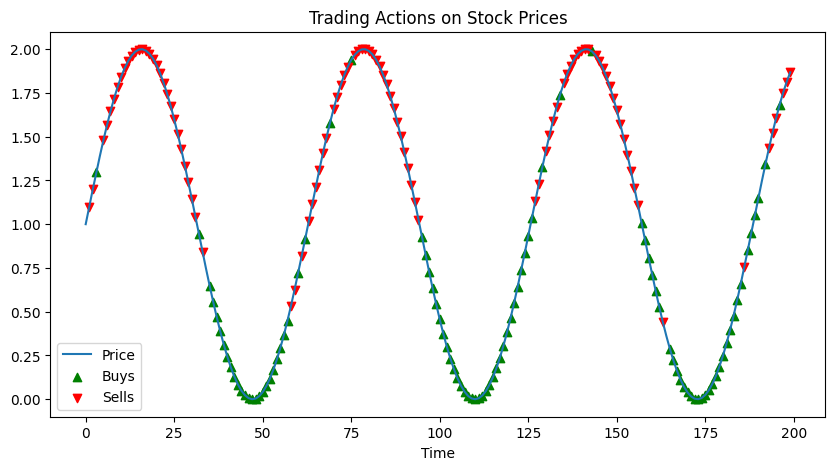

In [20]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(prices["Open"], label="Price")
ax.scatter(buys_x, buys_y, marker="^", color="g", label="Buys")
ax.scatter(sells_x, sells_y, marker="v", color="r", label="Sells")
ax.set_title("Trading Actions on Stock Prices")
ax.set_xlabel("Time")
ax.legend()
plt.show()
